# EXOTIC FRUIT CLASSIFICATION 
*Fourth Master AI Engineering project*

## Import Libraries and Dataset

* The Python packages I used in this projects are in requirements.txt file
* Dataset is stored in the 'Data' folder
* I renamed the columns for two reasons:
    - I need to translate Italian column names into English ones
    - I didn't want measurement units and ranges in the column names

In [1]:
# Import libraries

from pandas import read_csv
from numpy import arange
from pygwalker import walk

from src.preprocessing_and_viz import handle_duplicates, histogram_for_single_feature, scatter_plot, kde_for_single_feature, feature_scaling
from src.ml_functions import data_split, knn_optimization, viz_grid_search_res, evaluate_model, evaluate_knn_neighbors, plot_cv_results 
from src.ml_functions import cross_validation_model, plot_line_accuracy_log_loss, plot_bar_metrics, plot_violin_metric

In [2]:
# Import Dataset

df = read_csv("Data/Fruits_Dataset.csv")

df.head()

,Frutto,Peso (g),Diametro medio (mm),Lunghezza media (mm),Durezza buccia (1-10),Dolcezza (1-10)
0,Mela,86.40,89.68,8.69,9.61,2.41
1,Mela,77.58,73.45,6.49,7.20,3.87
2,Mela,81.95,81.66,6.40,9.09,2.88
3,Mela,66.33,36.71,6.78,8.21,2.55
4,Mela,56.73,75.69,5.78,9.15,3.88


In [3]:
# Renaming columns

new_columns = [
    'Fruit',
    'Weight',
    'Average diameter',
    'Average length',
    'Peel hardness',
    'Sweetness',
]

df.columns = new_columns

df.columns

Index(['Fruit', 'Weight', 'Average diameter', 'Average length',
       'Peel hardness', 'Sweetness'],
      dtype='object')

## Statistics Information

Useful information I got:
* Shape: (500,6)
* `Fruit` is the target column. There are 5 options: Apple, Banana, Orange, Grape, Kiwi
* 5 numerical features with continous values (float64)
* Statistics:
    - mean values and ranges are one order of magnitude different, I will implement normalization/standardization
    - Maximum value for Peel hardness should have been 10, but it's clearly higher (13.72). Strange!
    - it seems there are no missing values 

In [4]:
# Shape and Info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Fruit             500 non-null    object 
 1   Weight            500 non-null    float64
 2   Average diameter  500 non-null    float64
 3   Average length    500 non-null    float64
 4   Peel hardness     500 non-null    float64
 5   Sweetness         500 non-null    float64
dtypes: float64(5), object(1)
memory usage: 23.6+ KB


In [5]:
# Statistics

df.describe()

,Weight,Average diameter,Average length,Peel hardness,Sweetness
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,47.313440,86.573100,5.298620,7.437640,3.593220
std,26.768797,64.293403,2.641993,1.812548,1.264899
min,8.570000,7.530000,1.150000,3.070000,1.250000
25%,24.797500,50.510000,2.672500,6.152500,2.570000
50%,42.380000,70.450000,5.670000,7.340000,3.535000
75%,68.080000,88.852500,7.455000,8.615000,4.465000
max,111.210000,299.890000,11.140000,13.720000,6.950000


In [6]:
# Rename Target values and see how they are distributed

target_value_names = {
    'Mela' : 'Apple',
    'Banana' : 'Banana',
    'Arancia' : 'Orange',
    'Uva' : 'Grape',
    'Kiwi' : 'Kiwi'
}

df['Fruit'] = df['Fruit'].map(lambda x: target_value_names[x])

df['Fruit'] = df['Fruit'].astype('category')

df['Fruit'].value_counts()

Fruit
Apple     100
Banana    100
Grape     100
Kiwi      100
Orange    100
Name: count, dtype: int64

## Preprocessing

* No duplicates in the dataset. Shape is still (500,6)
* No missing values in the dataset.

In [9]:
# Check for duplicates

df_cleaned = handle_duplicates(df)

No duplicates found!


In [10]:
# Check for missing values

df_cleaned.isna().sum()

Fruit               0
Weight              0
Average diameter    0
Average length      0
Peel hardness       0
Sweetness           0
dtype: int64

## Data Visualization

Feature distribution without comparison with target column:
* Weight: as expected, it is a negatively skewed distribution with high max value (111.21)
* Average diameter: it is clear we have smaller fruits, so distribution is negatively skewed, with higher values come from Banana target
* Average length: its distribution has two peaks, sign of fruits with well separated lengths
* Peel hardness: has a almost normal distribution with a couple of possible outliers, median and mean are quite the same
* Sweetness: has a almost normal distribution, median and mean are quite the same

Feature distribution and scatter plot and comparison with target column:
* Weight, Average diameter, Average length: each fruit follows distributions that were expected, interesting how Apple, Orange and Kiwi have almost the same distribution for Average diameter
* Peel hardness: each fruit seems to follow a normal distribution
* Sweetness: Orange, Grape and Kiwi reach higher values, as expected

Scatter plot to see how features are distributed according to target column:
* Weight vs Average diameter: it is possible to clearly see two clusters for Banana and Grape. Maybe, Apple, Orange and Kiwi will be more difficult to classify
* Average length vs Average diameter: this plot emphasizes what said before 
* Peel hardness vs Weight: lighter fruits have higher Peel hardness values
* Sweetness vs Average diameter: smaller fruits have higher Sweetness values
* Peel hardness vs Sweetness: Banana has lowest Sweetness values and well distributed Peel hardness values. Orange, instead, had higher Sweetness values and lowest Peel hardness values

In [11]:
# Feature distribution among ['Weight', 'Average diameter', 'Average length', 'Peel hardness', 'Sweetness']

feature_to_viz = 'Weight'

fig = histogram_for_single_feature(df_cleaned, feature_to_viz, comparison=False)
fig.show()

In [12]:
# Feature distribution among ['Weight', 'Average diameter', 'Average length', 'Peel hardness', 'Sweetness']
# and comparison with TARGET 'Fruit' 

feature_to_viz = 'Sweetness'

fig = histogram_for_single_feature(df_cleaned, feature_to_viz, comparison='Fruit')
fig.show()

In [13]:
# Scatter plot among ['Weight', 'Average diameter', 'Average length', 'Peel hardness', 'Sweetness']
# and comparison with TARGET 'Fruit' 

feature_x = 'Sweetness'
feature_y = 'Average diameter'

fig = scatter_plot(df_cleaned, feature_x, feature_y, target='Fruit')
fig.show()

In [14]:
# Visualization Dashboard using PYGWALKER, you can see interactively the last plots
# You can save the json file for the configuration you want to visualize and make other people see it using this code:
# pyg.walk(df_cleaned, spec="Images/pygwalker_config_1.json")


walk(df_cleaned)

Box(children=(HTML(value='\n<div id="ifr-pyg-000622523127f5c7NDoPsWQgcOiUMh50" style="height: auto">\n    <hea…

## Feature Engineering 

Two options:
* Feature scaling only with MinMaxScaler method: 
    - it allows me to have all features in the same range of values [0,1]
    -  intuitive and fast to implement
* Feature scaling only with StandardScaler method:
    - it's useful to get stable and robust distributions from a statistically point of view, bringing all features to mean 0 and std 1
    - in this dataset, features are close, or at least quite close, to normal distribution

**My decision** is to use `StandardScaler` because:
1. in this dataset, there are feature that should be normally distributed. All of them are properties of some fruits, so increasing the numebr of instances I think they will follow a Gaussian distribution
2. MinMax scaler compresses data to a fixed range, it could cause a loss of significant information

In [15]:
# Feature scaling with MinMaxScaler method

df_minmax_transformed = feature_scaling(df_cleaned, method = 'MinMax')
df_minmax_transformed.describe().map(lambda x: f"{x:.2f}")

,Weight,Average diameter,Average length,Peel hardness,Sweetness
count,500.00,500.00,500.00,500.00,500.00
mean,0.38,0.27,0.42,0.41,0.41
std,0.26,0.22,0.26,0.17,0.22
min,0.00,0.00,0.00,0.00,0.00
25%,0.16,0.15,0.15,0.29,0.23
50%,0.33,0.22,0.45,0.40,0.40
75%,0.58,0.28,0.63,0.52,0.56
max,1.00,1.00,1.00,1.00,1.00


In [16]:
# Feature scaling with StandardScaler method

df_standard_transformed = feature_scaling(df_cleaned, method = 'Standard')
df_standard_transformed.describe().map(lambda x: f'{x:.2f}')

,Weight,Average diameter,Average length,Peel hardness,Sweetness
count,500.00,500.00,500.00,500.00,500.00
mean,-0.00,-0.00,0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00
min,-1.45,-1.23,-1.57,-2.41,-1.85
25%,-0.84,-0.56,-0.99,-0.71,-0.81
50%,-0.18,-0.25,0.14,-0.05,-0.05
75%,0.78,0.04,0.82,0.65,0.69
max,2.39,3.32,2.21,3.47,2.66


## Visualization after feature engineering

This is a section to visualize the transformed data using:
* distplot with normal distribution, with also histogram and rug plot for each feature
* distribution with histogram and box plot for each feature, including meand and std values
* scatter plots with target column comparison

In [17]:
# Distplot with Normal Distribution among ['Weight', 'Average diameter', 'Average length', 'Peel hardness', 'Sweetness']]

feature_to_viz = 'Peel hardness'

fig = kde_for_single_feature(df_standard_transformed, feature_to_viz, bin=0.2)
fig.show()

In [19]:
# Feature distribution among ['Weight', 'Average diameter', 'Average length', 'Peel hardness', 'Sweetness']

feature_to_viz = 'Sweetness'

fig = histogram_for_single_feature(df_standard_transformed, feature_to_viz, comparison=False)
fig.show()

In [20]:
# Scatter plot among ['Weight', 'Average diameter', 'Average length', 'Peel hardness', 'Sweetness']
# and comparison with TARGET 'Fruit' 

feature_x = 'Sweetness'
feature_y = 'Average diameter'

fig = scatter_plot(df_standard_transformed, feature_x, feature_y, target='Fruit')
fig.show()

## Saving transformed dataset

In [ ]:
# Saving dataset transformed with StandardScaler

df_standard_transformed.to_csv("Data/Fruits_Dataset_Preprocessed_Standard.csv", index=False)

In [ ]:
# Saving dataset transformed with MinMaxScaler

df_minmax_transformed.to_csv("Data/Fruits_Dataset_Preprocessed_MinMax.csv", index=False)

##  K-Nearest Neighbors (KNN) implementation and Results

Evaluate KNN algorithms using a train_test_split and a GridSearchCV optimization for the number of neighbours:
1. splitting the dataset in a stratify way
2. optimization procedure with GridSearchCV to find the best KNN model with the number of neighbours that reaches the highest accuracy score in validation test
3. `Results`:
    * I found that the best number of neighbours is 6 with an accuracy score 0.925 for test set. 
    * Error Bar Plot shows that effectively the best number of neighbours is 6 it has the best mean score value for the test set and one of the highest mean score value for training set, so to avoind overfitting
    * Classification Report and Confusion Matrix: Appli, Grape and Banana are the labels with the highest scores (accuracy, precision and recall), I found that this KNN model has evident lower performance for Orange. A possible solution could be to find a more balanced model that minimize the performance on other classes to increase this one, or in addition, I need to understand which could be the most important class to predict from the domain specialist. The last possibility could be to use a more complex model such as SVM and Random Forest, in order to see if it is possible to find better performce increasing model complexity.

Evaluate KNN algorithms using a stratified K-folds cross-validation for each number of neighbours in [1,20]:
1. this solution is an alternative method of the previous one, it helps to find the best number of neighbors for the KNN model
2. This implementation has the advantage to see directly the metrics scores for both training and test and using different metrics like accuracy and log loss. Moreover, using a manual cross-validation helps to set parameters and increase robustness of the results.
3. `Results`:
    * I practically found the same results I found before, the best number of neighbours is 6
    * These results are fundamental, from my point of view, they increase the validity of what I found in the other method
    * From accuraccy and log loss plots is possible to visualize these results, finding the best ratio beetween training and test for number of neighbours equals to 6 for accuracy, and maybe it is equal to 7 for log loss.

Evaluate the best KNN model with number of neighbors 6 in a stratified k-folds cross-validation to increase statistics and robustness of the model:
1. the cross-validation has 10 folds and it is stratified, the function saves results for these metrics: accuracy, precision, recall, f1 score, log loss
2. for this subsection, I visualize data using `Plotly` to have an interactive view of these results in order to manage all these metrics. I used scatter plots for each metric over the folds, bar plots to compared mean and std for each metric, volin plot for a choosen metric
3. `Results`:
    * metrcis scores for training set is, as expected, more stable than test set
    * this behaviour is evident from scatter plot and std values, but mean values for training and test sets are comparable for each metric (for example, accuracy is 95% for training and 94% for testing, similar results for other metrics)
    * violin plots help me to see the results distributions, it is normal for each metric and test (very good performance when seeing results from a classifier model) and, as said before, these training results are more stable presenting a lower variance range than test set.

In [2]:
# Import Transformed Dataset

df_standard_transformed = read_csv("Data/Fruits_Dataset_Preprocessed_Standard.csv")
df_standard_transformed.head()

,Weight,Average diameter,Average length,Peel hardness,Sweetness,Fruit
0,1.461616,0.048372,1.284930,1.199712,-0.936364,Apple
1,1.131798,-0.204317,0.451391,-0.131240,0.219035,Apple
2,1.295211,-0.076493,0.417292,0.912536,-0.564420,Apple
3,0.711112,-0.776332,0.561267,0.426545,-0.825572,Apple
4,0.352126,-0.169442,0.182386,0.945671,0.226949,Apple


In [3]:
# Splitting dataset

label = 'Fruit'

X_train, X_test, y_train, y_test = data_split(df_standard_transformed, label, test_size=0.2)

print("="*40)
print(f"Dataset Shape before splitting: {df_standard_transformed.shape}")
print(f"X train Shape after splitting: {X_train.shape}")
print(f"X test Shape after splitting: {X_test.shape}")
print(f"y train Shape after splitting: {y_train.shape}")
print(f"y test Shape after splitting: {y_test.shape}")
print("="*40)

Dataset Shape before splitting: (500, 6)
X train Shape after splitting: (400, 5)
X test Shape after splitting: (100, 5)
y train Shape after splitting: (400,)
y test Shape after splitting: (100,)


In [24]:
# Check for target distribution in y_test

y_test.value_counts()

Fruit
Grape     20
Apple     20
Kiwi      20
Banana    20
Orange    20
Name: count, dtype: int64

In [4]:
# Optimizing KNN model with GridSearchCV

grid = {
    'n_neighbors' : arange(1,20)
}

best_knn_model, results_cv_search = knn_optimization(X_train, y_train, params=grid, k_cv=5, save_res = True)

Best parameters: {'n_neighbors': 6}
Best model: KNeighborsClassifier(n_neighbors=6)
Best accuracy score: 0.925

Results saved...


/var/folders/8d/09j2zdrx7klfl7nffqz630000000gn/T/ipykernel_11298/1562936619.py:4: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



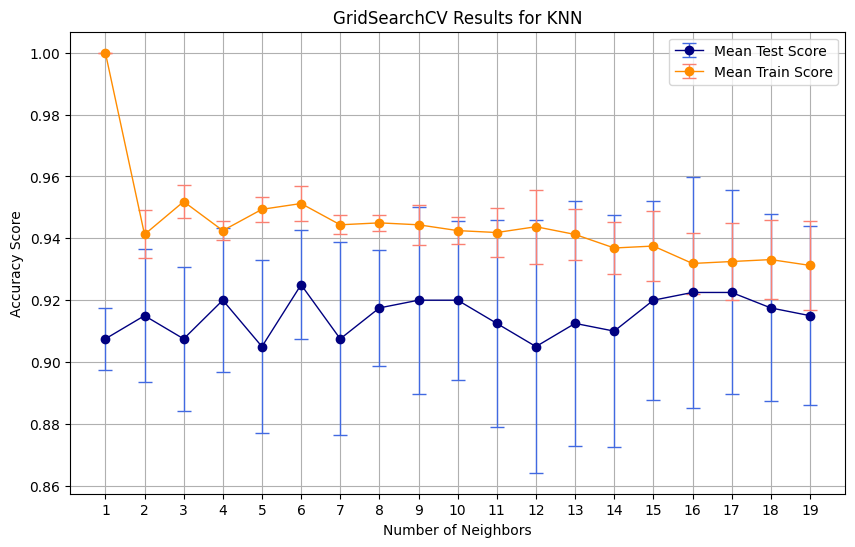

In [26]:
# Visualize results from GridSearchCV with KNN

fig = viz_grid_search_res(results_cv_search)
fig.show()

Accuracy: 0.93
Classification Report:
              precision    recall  f1-score   support

       Apple       0.87      1.00      0.93        20
      Banana       1.00      1.00      1.00        20
       Grape       1.00      1.00      1.00        20
        Kiwi       0.86      0.90      0.88        20
      Orange       0.94      0.75      0.83        20

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100



/var/folders/8d/09j2zdrx7klfl7nffqz630000000gn/T/ipykernel_11298/940734075.py:4: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



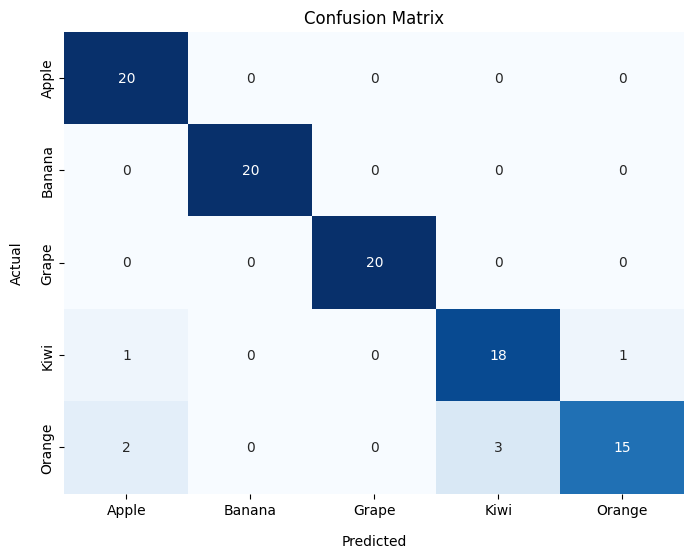

In [27]:
# Model evaluation on Test set

fig, ax = evaluate_model(best_knn_model, X_test, y_test)
fig.show()

In [5]:
# k-folds Stratified Cross Validation to find the number of neighbors fot the best KNN model

results_cv = evaluate_knn_neighbors(df_standard_transformed, target='Fruit', min_neighbors=1, max_neighbors=20, cv=10)

----------------------------------------------------------------------------------------------------
n_neighbors=1: Train Accuracy=1.0000 Test Accuracy=0.9160 Train Log Loss=0.0000 Test Log Loss=3.0277
----------------------------------------------------------------------------------------------------
n_neighbors=2: Train Accuracy=0.9576 Test Accuracy=0.9020 Train Log Loss=0.0604 Test Log Loss=1.5332
----------------------------------------------------------------------------------------------------
n_neighbors=3: Train Accuracy=0.9544 Test Accuracy=0.9160 Train Log Loss=0.1015 Test Log Loss=1.0493
----------------------------------------------------------------------------------------------------
n_neighbors=4: Train Accuracy=0.9449 Test Accuracy=0.9140 Train Log Loss=0.1152 Test Log Loss=0.5038
----------------------------------------------------------------------------------------------------
n_neighbors=5: Train Accuracy=0.9393 Test Accuracy=0.9140 Train Log Loss=0.1216 Test Log Lo

/var/folders/8d/09j2zdrx7klfl7nffqz630000000gn/T/ipykernel_11298/3897466515.py:4: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



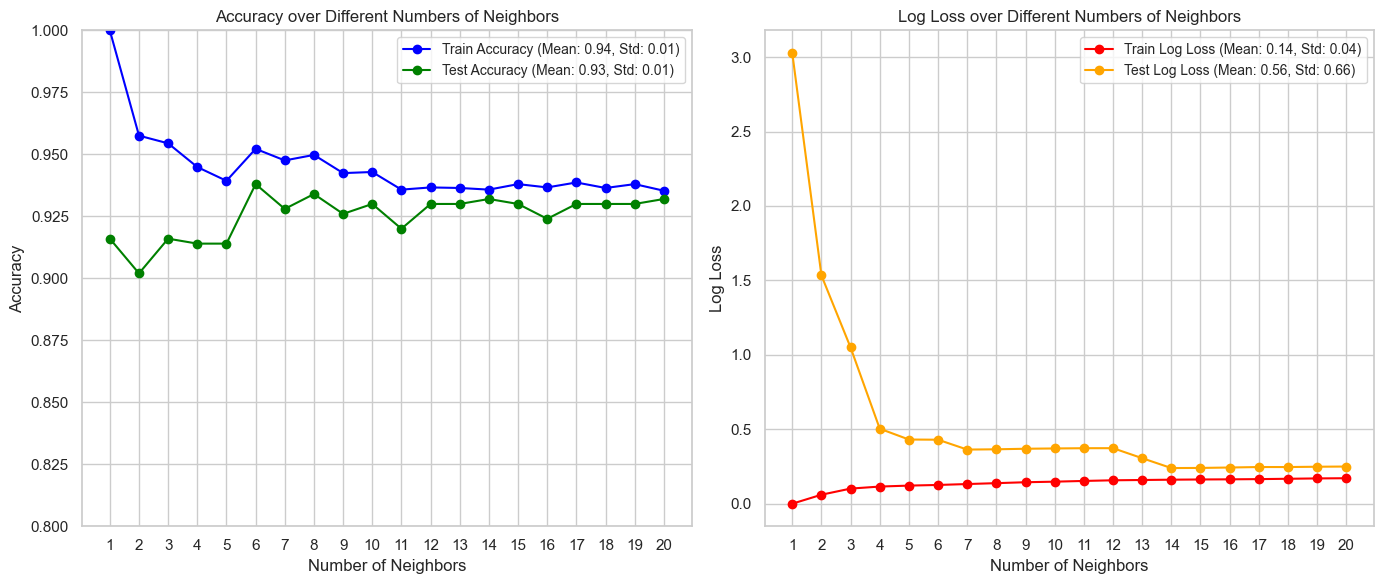

In [29]:
# Visualize Cross-Validation Results

fig, ax1, ax2 = plot_cv_results(results_cv)
fig.show()

In [6]:
# Cross Validation using the number of neighbors according to the best KNN model to evaluate statically robustness of the model

results_cv_knn = cross_validation_model(df_standard_transformed, target='Fruit', n_neighbors=6, cv=10)

Training KNN in Fold 1...
Training KNN in Fold 2...
Training KNN in Fold 3...
Training KNN in Fold 4...
Training KNN in Fold 5...
Training KNN in Fold 6...
Training KNN in Fold 7...
Training KNN in Fold 8...
Training KNN in Fold 9...
Training KNN in Fold 10...


In [8]:
# Visualize Cross-Validation results: Scatter Plot for a choosen metric over the folds
# metrics names = accuracy, precision, recall, f1, loss

fig = plot_line_accuracy_log_loss(results_cv_knn, metric='loss')
fig.show()

In [9]:
# Visualize Cross-Validation results: Scatter Plot for a choosen metric over the folds
# metrics names = accuracy, precision, recall, f1, loss

fig = plot_line_accuracy_log_loss(results_cv_knn, metric='accuracy')
fig.show()

In [7]:
# Bar plots to see KNN model performances (mean and std)

fig = plot_bar_metrics(results_cv_knn)
fig.show()

In [12]:
# Violin Plot for a choosen metric among 'accuracy', 'precision', 'recall', 'f1', 'loss' both train and test 

fig = plot_violin_metric(results_cv_knn, 'f1')
fig.show()

## [EXTRA] Try other Machine Learning Classifiers
*This section has the purpose to see how other ML classifiers could perfome respect to KNN*
**This section could be refactored, at the moment, it something to be done**

- Results:
    1. KNN reached 92% accuracy in training and 93% in test
    2. SVM has the best perfomances with >93% in training and 93% in test, grid search is a little bit slower than KNN
    3. worst performance with Decision Tree, maybe it is too simple for a multiclass problem like this
    4. Linear Discriminant Analysis and Random Forest have similar results respect to KNN 
    5. XGBoost seems to suffer of underfitting

In [8]:
# Import Libraries

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from src.ml_functions import model_optimization
from src.constants import RANDOM_SEED

In [9]:
# Import Transformed Dataset

df_standard_transformed = read_csv("Data/Fruits_Dataset_Preprocessed_Standard.csv")
df_standard_transformed.head()

,Weight,Average diameter,Average length,Peel hardness,Sweetness,Fruit
0,1.461616,0.048372,1.284930,1.199712,-0.936364,Apple
1,1.131798,-0.204317,0.451391,-0.131240,0.219035,Apple
2,1.295211,-0.076493,0.417292,0.912536,-0.564420,Apple
3,0.711112,-0.776332,0.561267,0.426545,-0.825572,Apple
4,0.352126,-0.169442,0.182386,0.945671,0.226949,Apple


In [10]:
# Splitting dataset

label = 'Fruit'

X_train, X_test, y_train, y_test = data_split(df_standard_transformed, label, test_size=0.2)

print("="*40)
print(f"Dataset Shape before splitting: {df_standard_transformed.shape}")
print(f"X train Shape after splitting: {X_train.shape}")
print(f"X test Shape after splitting: {X_test.shape}")
print(f"y train Shape after splitting: {y_train.shape}")
print(f"y test Shape after splitting: {y_test.shape}")
print("="*40)

Dataset Shape before splitting: (500, 6)
X train Shape after splitting: (400, 5)
X test Shape after splitting: (100, 5)
y train Shape after splitting: (400,)
y test Shape after splitting: (100,)


### Linear Discriminant Analysis

In [11]:
# Linear Discriminant Analysis Model and Parameter grid

lda_model = LinearDiscriminantAnalysis()
lda_param_grid = {
    'solver': ['svd', 'lsqr', 'eigen'],  # Solver for LDA
    'shrinkage': [None, 'auto', 0.1, 0.5, 1.0],  # Shrinkage parameter for 'lsqr' and 'eigen' solvers
    'tol': [1e-4, 1e-3, 1e-2, 1e-1]  # Tolerance for the solver convergence
}

best_model, results_df = model_optimization(X_train, y_train, lda_model, lda_param_grid, k_cv=5, scoring='accuracy', save_res=True, 
                                            results_filename="results_lda_gridsearch_cv.csv")

Best parameters: {'shrinkage': 0.1, 'solver': 'lsqr', 'tol': 0.0001}
Best model: LinearDiscriminantAnalysis(shrinkage=0.1, solver='lsqr')
Best accuracy score: 0.9225

Results saved to Results/results_lda_gridsearch_cv.csv


Accuracy: 0.94
Classification Report:
              precision    recall  f1-score   support

       Apple       0.86      0.95      0.90        20
      Banana       1.00      1.00      1.00        20
       Grape       1.00      1.00      1.00        20
        Kiwi       0.90      0.95      0.93        20
      Orange       0.94      0.80      0.86        20

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100



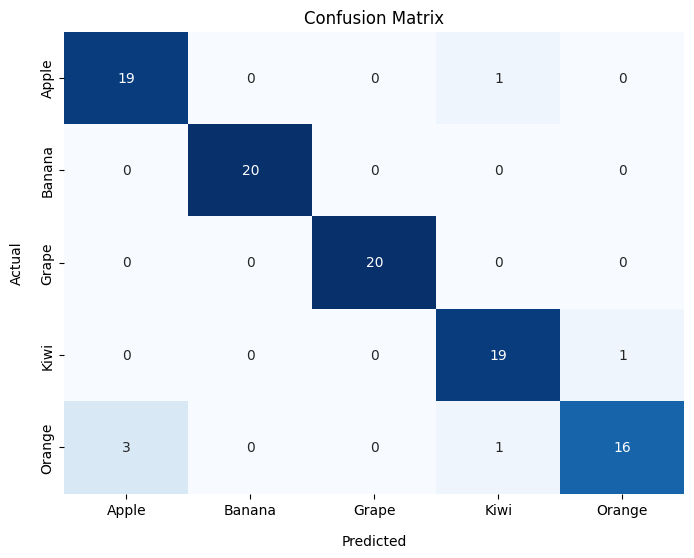

In [14]:
# Model evaluation on Test set

fig, fig_2 = evaluate_model(best_model, X_test, y_test)
fig.show()

### SVM

In [16]:
# SVM Model and Parameter grid

svm_model = SVC()
svm_param_grid = {
    'C': [0.1, 1, 10, 20],  # Regularization parameter. Inverse of regularization strength, smaller values specify stronger regularization.
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel type
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    'degree': [2, 3, 4],  # Degree of the polynomial kernel function (if kernel is 'poly')
    'coef0': [0.0, 0.1, 0.5]  # Independent term in kernel function (for 'poly' and 'sigmoid')
}

best_model, results_df = model_optimization(X_train, y_train, svm_model, svm_param_grid, k_cv=5, scoring='accuracy', save_res=True, 
                                            results_filename="results_svm_gridsearch_cv.csv")

Best parameters: {'C': 0.1, 'coef0': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'sigmoid'}
Best model: SVC(C=0.1, coef0=0.1, degree=2, kernel='sigmoid')
Best accuracy score: 0.9324999999999999

Results saved to Results/results_svm_gridsearch_cv.csv


Accuracy: 0.93
Classification Report:
              precision    recall  f1-score   support

       Apple       0.86      0.95      0.90        20
      Banana       1.00      1.00      1.00        20
       Grape       1.00      1.00      1.00        20
        Kiwi       0.94      0.85      0.89        20
      Orange       0.85      0.85      0.85        20

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100



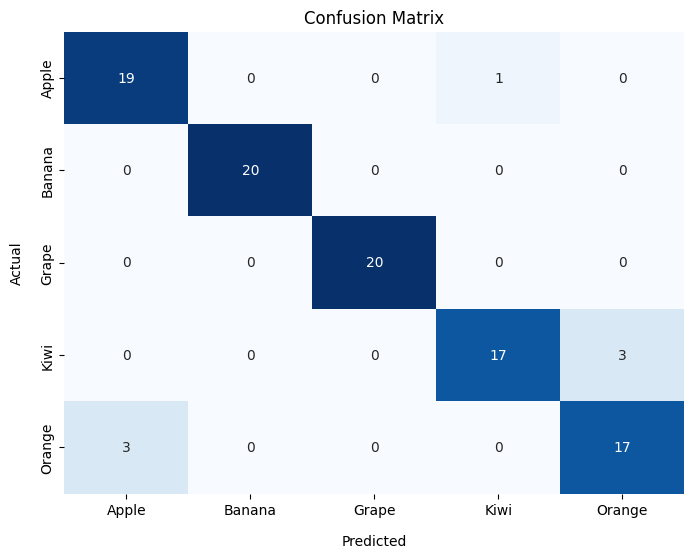

In [17]:
# Model evaluation on Test set

fig, fig_2 = evaluate_model(best_model, X_test, y_test)
fig.show()

### Decision Tree

In [18]:
# Decision Tree Model and Parameter grid

dt_model = DecisionTreeClassifier(random_state=RANDOM_SEED)
dt_param_grid = {
    'criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
    'max_depth': [None, 5, 10, 15, 20],  # If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider when looking for the best split. If None, then max_features=n_features.
    'splitter': ['best', 'random']  # The strategy used to choose the split at each node
}

best_model, results_df = model_optimization(X_train, y_train, dt_model, dt_param_grid, k_cv=5, scoring='accuracy', save_res=True, 
                                            results_filename="results_dt_gridsearch_cv.csv")

Best parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'random'}
Best model: DecisionTreeClassifier(min_samples_leaf=4, min_samples_split=10,
                       random_state=59, splitter='random')
Best accuracy score: 0.8925000000000001

Results saved to Results/results_dt_gridsearch_cv.csv


Accuracy: 0.89
Classification Report:
              precision    recall  f1-score   support

       Apple       0.76      0.95      0.84        20
      Banana       1.00      1.00      1.00        20
       Grape       1.00      1.00      1.00        20
        Kiwi       0.89      0.85      0.87        20
      Orange       0.81      0.65      0.72        20

    accuracy                           0.89       100
   macro avg       0.89      0.89      0.89       100
weighted avg       0.89      0.89      0.89       100



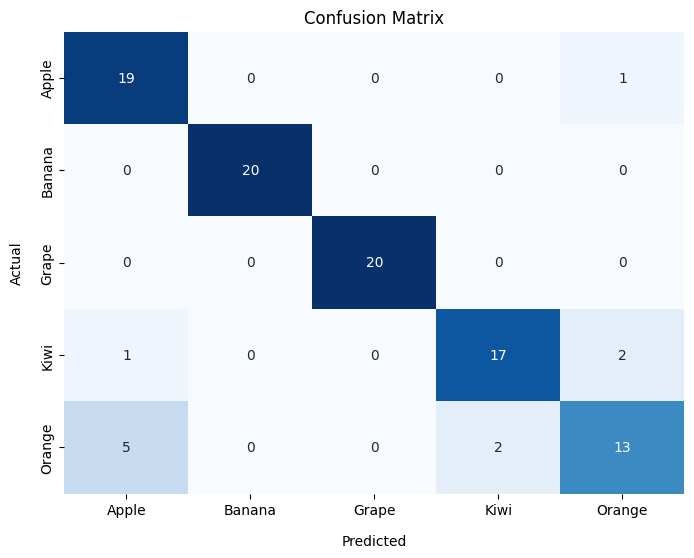

In [19]:
# Model evaluation on Test set

fig, fig_2 = evaluate_model(best_model, X_test, y_test)
fig.show()

### Random Forest

In [20]:
# Random Forest Model and Parameter grid

rf_model = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1)
rf_param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 5, 10, 20, 30],  
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider when looking for the best split
    'criterion': ['gini', 'entropy']  # Function to measure the quality of a split
}

best_model, results_df = model_optimization(X_train, y_train, rf_model, rf_param_grid, k_cv=5, scoring='accuracy', save_res=True, 
                                            results_filename="results_rf_gridsearch_cv.csv")

Best parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best model: RandomForestClassifier(max_depth=10, min_samples_split=5, n_jobs=-1,
                       random_state=59)
Best accuracy score: 0.9275

Results saved to Results/results_rf_gridsearch_cv.csv


Accuracy: 0.93
Classification Report:
              precision    recall  f1-score   support

       Apple       0.79      0.95      0.86        20
      Banana       1.00      1.00      1.00        20
       Grape       1.00      1.00      1.00        20
        Kiwi       1.00      0.85      0.92        20
      Orange       0.89      0.85      0.87        20

    accuracy                           0.93       100
   macro avg       0.94      0.93      0.93       100
weighted avg       0.94      0.93      0.93       100



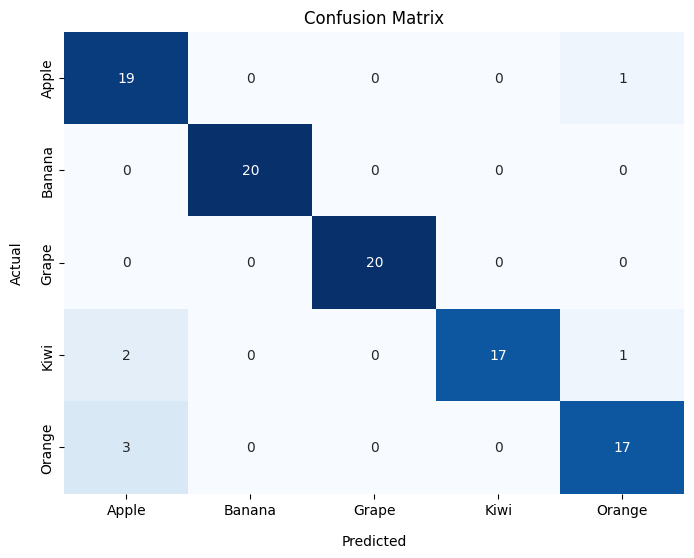

In [21]:
# Model evaluation on Test set

fig, fig_2 = evaluate_model(best_model, X_test, y_test)
fig.show()

### XGBoost

In [22]:
# XGBoost Model and Parameter grid

xgb_model = XGBClassifier(eval_metric='mlogloss', n_jobs = -1)

xgb_param_grid = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [3, 6, 10],  
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage
    'gamma': [0, 0.1, 0.2]  # Minimum loss reduction to make a further partition on a leaf node
}


target_value_names = {
    'Apple' : 0,
    'Banana' : 1,
    'Orange' : 2,
    'Grape' : 3,
    'Kiwi' : 4
}
y_train = y_train.map(lambda x : target_value_names[x])

best_model, results_df = model_optimization(X_train, y_train, xgb_model, xgb_param_grid, k_cv=5, scoring='accuracy', save_res=True, 
                                            results_filename="results_xgb_gridsearch_cv.csv")

Best parameters: {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50}
Best model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=-1, num_parallel_tree=None, objective='multi:softprob', ...)
Best accuracy score: 0.915

Results saved to Results/results_xgb_gridsearch_cv.csv


Accuracy: 0.94
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.88        20
           1       1.00      1.00      1.00        20
           2       0.89      0.85      0.87        20
           3       1.00      1.00      1.00        20
           4       1.00      0.90      0.95        20

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100



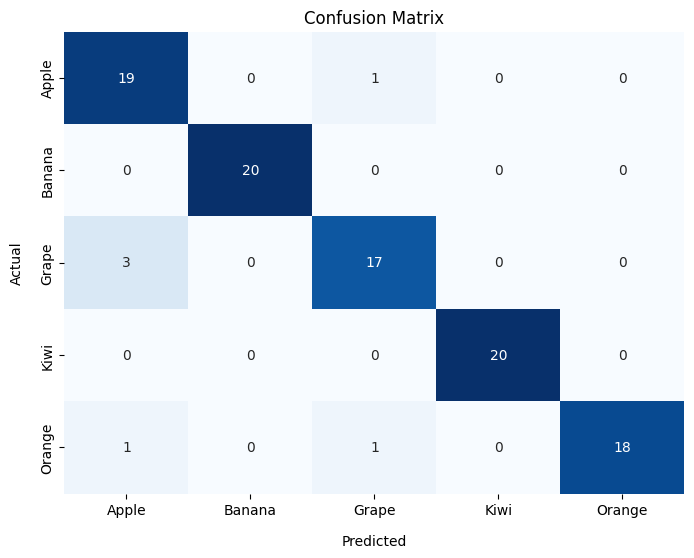

In [23]:
# Model evaluation on Test set

target_value_names = {
            'Apple' : 0,
            'Banana' : 1,
            'Orange' : 2,
            'Grape' : 3,
            'Kiwi' : 4
        }
y_test = y_test.map(lambda x : target_value_names[x])

fig, fig_2 = evaluate_model(best_model, X_test, y_test)
fig.show()